<h1>Deep-dentistry model for decay analysis</h1>

In [1]:
#Setting up resources and libraries required

import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Flatten, Dense
from keras.layers.convolutional import *
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [2]:
#Local and relative paths to the files are used..
train_path = 'Data/train'
valid_path = 'Data/validate'
test_path = 'Data/test'

In [3]:
train_bconvert = ImageDataGenerator().flow_from_directory(train_path,target_size=(64,64),classes=['DECAYED','DECAYFREE'],batch_size=20)
valid_bconvert = ImageDataGenerator().flow_from_directory(valid_path,target_size=(64,64),classes=['DECAYED','DECAYFREE'],batch_size=10)
test_bconvert = ImageDataGenerator().flow_from_directory(test_path,target_size=(64,64),classes=['DECAYED','DECAYFREE'],batch_size=20)

Found 1234 images belonging to 2 classes.
Found 307 images belonging to 2 classes.
Found 386 images belonging to 2 classes.


In [6]:
# Function plots images with labels
def plots(ims, figsize=(24,12), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [5]:
imgs, labels = next(train_bconvert)

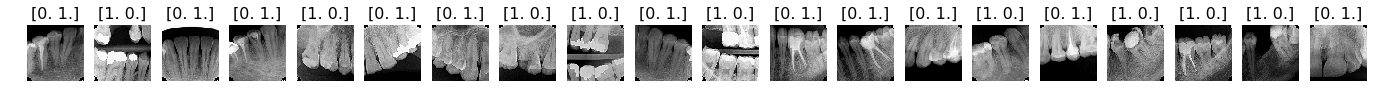

In [7]:
plots(imgs, titles=labels)

<h2>Network Architecture</h2>

In [22]:
input1 = keras.layers.Input(shape=(64, 64, 3))
C1 = Conv2D(32, (3, 3), strides=(2, 2), activation='linear', input_shape=(64,64,3),
                kernel_regularizer=regularizers.l2(9.999999747378752e-05), padding='valid')(input1)
BN1 = BatchNormalization(axis=-1, epsilon=0.001, mode=0, momentum=0.99, weights=None)(C1)
A1 = Activation('relu')(BN1)
C2=Conv2D(64, (3, 3), strides=(1, 1), activation='linear', input_shape=(64,64,3),
                kernel_regularizer=regularizers.l2(9.999999747378752e-05), padding='same')(A1)
BN2 = BatchNormalization(axis=-1, epsilon=0.001, mode=0, momentum=0.99, weights=None)(C2)
A2 = Activation('relu')(BN2)
C_sep_1 = SeparableConv2D(64, (3, 3),dilation_rate=(1, 1), depth_multiplier=1, strides=(1, 1),padding='same',
            activation='linear',depthwise_initializer='Zeros', kernel_regularizer=regularizers.l2(9.999999747378752e-05),
                         use_bias=True, pointwise_initializer='glorot_uniform', bias_initializer='zeros', 
                          depthwise_regularizer=regularizers.l2(9.999999747378752e-05), pointwise_regularizer=regularizers.l2(9.999999747378752e-05))(A2)
BN3 = BatchNormalization(axis=-1, epsilon=0.001, mode=0, momentum=0.99, weights=None)(C_sep_1)
add_1 = keras.layers.add([A2,BN3])
A3 = Activation('relu')(add_1)
DO3 = keras.layers.Dropout(rate=0.5, noise_shape=None, seed=None)(A3)
F1 = Flatten()(DO3)
out = keras.layers.Dense(units=2, activation='softmax', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', 
                        kernel_regularizer=None)(F1)
model = keras.models.Model(inputs=[input1], outputs=out)

C:\Users\DesignerBe\AppData\Local\conda\conda\envs\MLDL_env\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(axis=-1, epsilon=0.001, momentum=0.99, weights=None)`
  after removing the cwd from sys.path.
C:\Users\DesignerBe\AppData\Local\conda\conda\envs\MLDL_env\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(axis=-1, epsilon=0.001, momentum=0.99, weights=None)`
  
C:\Users\DesignerBe\AppData\Local\conda\conda\envs\MLDL_env\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(axis=-1, epsilon=0.001, momentum=0.99, weights=None)`
  


In [23]:
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 31, 31, 32)   896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 31, 31, 32)   128         conv2d_3[0][0]                   
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 31, 31, 32)   0           batch_normalization_4[0][0]      
__________________________________________________________________________________________________
conv2d_4 (

In [25]:
hist = model.fit_generator(train_bconvert, steps_per_epoch=55, 
                    validation_data=valid_bconvert, validation_steps=25, epochs=5, verbose=2) 

Epoch 1/5
 - 74s - loss: 0.9137 - acc: 0.5913 - val_loss: 0.9804 - val_acc: 0.6440
Epoch 2/5
 - 64s - loss: 0.7055 - acc: 0.7060 - val_loss: 0.6974 - val_acc: 0.6599
Epoch 3/5
 - 59s - loss: 0.5168 - acc: 0.7703 - val_loss: 0.7414 - val_acc: 0.6154
Epoch 4/5
 - 62s - loss: 0.3820 - acc: 0.8474 - val_loss: 0.7416 - val_acc: 0.6640
Epoch 5/5
 - 65s - loss: 0.3519 - acc: 0.8619 - val_loss: 0.7618 - val_acc: 0.6518


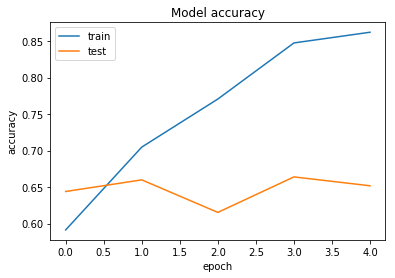

In [26]:
#Accuracy Plot
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

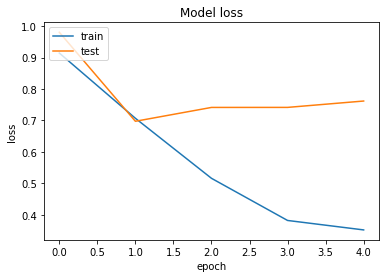

In [27]:
#loss Plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

<h2>Results</h2>

In [36]:
test_bconf = ImageDataGenerator().flow_from_directory(test_path,target_size=(64,64),classes=['DECAYED','DECAYFREE'],batch_size=100)
test_imgs, test_labels = next(test_bconf)

Found 386 images belonging to 2 classes.


In [37]:
test_labels = test_labels[:,0]
test_labels

array([1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0.,
       0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1.,
       1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1.,
       1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0.,
       1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0.],
      dtype=float32)

In [38]:
predictions = model.predict_generator(test_bconf, steps=1, verbose=0)


In [39]:
predictions=np.round(predictions,0)

In [40]:
cm = confusion_matrix(test_labels, predictions[:,0])

In [41]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[25 23]
 [12 40]]


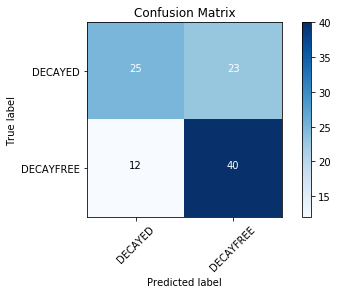

In [42]:
cm_plot_labels = ['DECAYED','DECAYFREE']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')